## Libraries

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq
import scipy.io.wavfile as wavfile
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import umap

## Functions

In [26]:
# This function reads the wave file and projects it
def retrieveFFTWav(wavFileLocation):
    try:
        sampleRate, wavSignal = wavfile.read(wavFileLocation)
    except:
        print(f"ERROR: could not open {wavFileLocation} file")
    return wavSignal, sampleRate

# wavFileLocation - file location of the .wav file
# timeStep - the step at time at which a fourier transformation is performed
def WavToFFT(wavSignal, sampleRate, timeStep):
    fftList = []

    # Step 1) Define Time Step
    newSampleRate = sampleRate * timeStep
    currSample = 0

    # Step 2) Iterate over signal
    while currSample < np.size(wavSignal):
        fftList.append(fft(wavSignal[int(currSample):int(currSample)+int(newSampleRate)]))
        currSample += int(newSampleRate)
    
    fftList = fftList[:-1] # remove last part in case it's not homogenous (i.e. not the same length as rest of values in list)
    return fftList

# This is used for PCA truncation using SVD. This was not used
def reduceXMatrix(xMatrix, PCATruncationValue):
    # Perform SVD
    U, S, Vt = np.linalg.svd(xMatrix, full_matrices=False)

    # Truncation Matrix
    diagonal = np.zeros(np.size(S), dtype=int)
    diagonal[:PCATruncationValue] = 1   

    print(np.size(S))
    # View PCA and truncate S
    S *= diagonal

    return np.dot(U, np.dot(np.diag(S), Vt))

# This function reconstructs the audio file and outputs it
def outputFFTArr(fftArr, sampleRate):
    reconstructedArr = []
    for fftSegment in fftArr:
        reconstructedArr.append(ifft(fftSegment).real)
    wavfile.write('reconstructed.wav', sampleRate, np.concatenate(reconstructedArr).astype(np.int16))

# This function is used to threshold the different values based on the percentile
def thresholdWav(wavSignal, threshold):
    fftSignal = fft(wavSignal)
    sortedVals = np.sort(np.abs(fftSignal))[::-1]
    fftSignal[np.abs(fftSignal) < sortedVals[int(np.size(sortedVals) * threshold)]] = 0.0
    return ifft(fftSignal)

# This function displays the different ways to set the min_dists and the n_neighbors of UMAP projection
def differentUMAPParameters(preprocessedNP):
    min_dists = [0, 0.01, 0.05, 0.1, 0.5, 1]
    n_neighbors = [5, 15, 30, 50, 100]
    fig, axs = plt.subplots(len(min_dists), len(n_neighbors), squeeze=False, figsize=(10, 10))
    fig.suptitle("Different UMAP Projections", fontsize=20)
    for i, min_d_val in enumerate(min_dists):
        for j, n_val in enumerate(n_neighbors):
            
            dataDimTechnique = umap.UMAP(n_components=2, min_dist=min_d_val, n_neighbors=n_val)
            testPCA = dataDimTechnique.fit_transform(preprocessedNP)
            axs[i,j].scatter(testPCA[:,0], testPCA[:,1])

            #remove tick information
            axs[i, j].set_xticks([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticks([])
            axs[i, j].set_yticklabels([])
            
            if (i == 0):
                axs[i,j].set_title(n_val)
            if (j == 0):
                axs[i,j].set_ylabel(min_d_val)
    plt.figure(figsize=(20, 20))
    plt.show()

# This functions finds the number of clusters using the DBSCAN method
def findClusters(fftArray, sampleRate):
    preprocessedData = []
    # Step 1) Preprocessing:
    for i, val in enumerate(fftArray):
        # Get only real values
        frequencies = fftfreq(len(val), 1 / sampleRate)
        frequencyValues = frequencies[frequencies >= 0]
        magnitudeValues = np.abs(val)[frequencies >= 0]
        timeStepValues = np.full(len(magnitudeValues), i+1)

        # V stack elements
        stackedElements = np.vstack((frequencyValues, magnitudeValues, timeStepValues)).T

        # Append to preprocessedData
        preprocessedData.extend(stackedElements.tolist())
    preprocessedNP = np.array(preprocessedData)

    # Remove data less than 5th percentile, threshold step
    maxPercentile = np.max(magnitudeValues) * 0.5
    preprocessedNP = preprocessedNP[preprocessedNP[:,1] > maxPercentile]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(preprocessedNP[:, 0], preprocessedNP[:, 2], preprocessedNP[:, 1])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Time Step")
    plt.title("Raw Data")
    plt.show()

    # Step 2) Change dimensionality to make sense
    dataDimTechnique = umap.UMAP(n_components=2)
    umapProjectionData = dataDimTechnique.fit_transform(preprocessedNP)
    plt.scatter(umapProjectionData[:, 0], umapProjectionData[:, 1])
    plt.title("Unclustered UMAP Data")
    plt.show()

    # Step 3) Find clusters
    dbscan = DBSCAN(eps=1, min_samples=2)
    labels = dbscan.fit_predict(umapProjectionData)
    curr_silhouette_score = silhouette_score(umapProjectionData, labels)
    print(f"Silhouette Score: {curr_silhouette_score}")
    plt.scatter(umapProjectionData[:, 0], umapProjectionData[:, 1], c=labels)
    plt.title(f"Number of clusters with DBSCAN: {len(set(labels)) - (1 if -1 in labels else 0)}")
    plt.show()
    print(f"Number of clusters {len(set(labels)) - (1 if -1 in labels else 0)}")

    # Step 4) Display UMAP Parameters
    differentUMAPParameters(preprocessedNP)

    return len(set(labels)) - (1 if -1 in labels else 0)

## Main

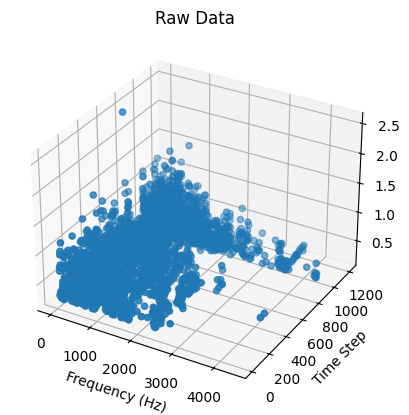

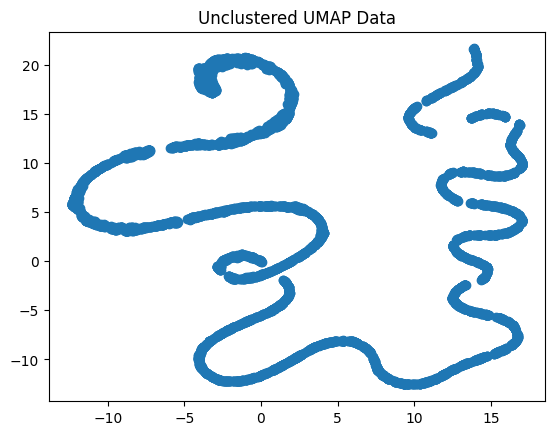

Silhouette Score: 0.387721449136734


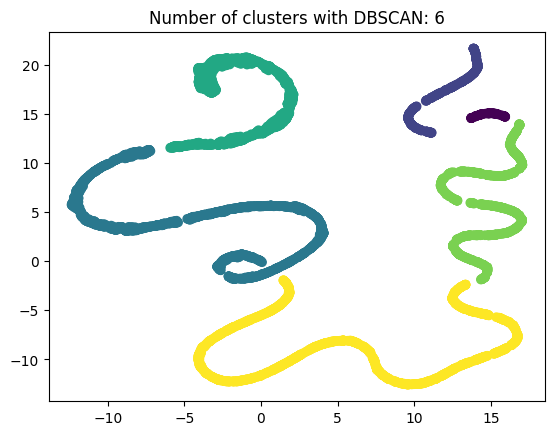

Number of clusters 6


c:\Users\alexc\OneDrive\Desktop\UnmaskingTheMelodies\venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\alexc\OneDrive\Desktop\UnmaskingTheMelodies\venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\alexc\OneDrive\Desktop\UnmaskingTheMelodies\venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\alexc\OneDrive\Desktop\UnmaskingTheMelodies\venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\alexc\OneDrive\Desktop\UnmaskingTheMelodies\venv\Lib\site-packages\sklearn\manifold\_sp

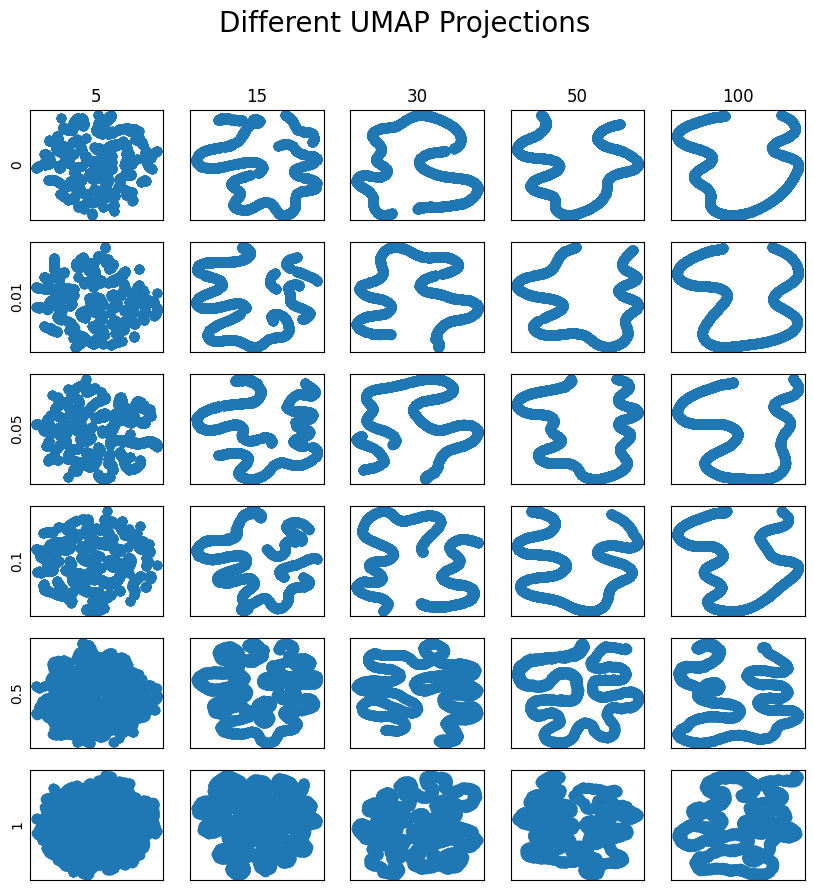

<Figure size 2000x2000 with 0 Axes>

In [27]:
if __name__ == "__main__":
    # How to use: Replace the "fileLocationString" variable with whatever .wav file you want.
    fileLocationString = "SampleWavFiles\CantinaBand60.wav"
    wavSignal, sampleRate = retrieveFFTWav("SampleWavFiles\CantinaBand60.wav")
    
    # Heuristic for sampling data to get ~ 1200 time frames
    wavSeconds = len(wavSignal) / sampleRate
    framesDuration = ( 0.05 / 60 ) * wavSeconds
    fftArr = WavToFFT(wavSignal, sampleRate, framesDuration)
    findClusters(fftArr, sampleRate)

    # reconstruct wave
    outputFFTArr(fftArr, sampleRate)